<a href="https://colab.research.google.com/github/Nishan-Charlie/e17-4yp-Applying-deep-learning-on-histological-images-of-lymph-tissues/blob/main/Fyp_HER2_VGG16_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
from tensorflow.keras.metrics import AUC
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

In [ ]:
base  = "/content/drive/MyDrive/Colab Notebooks/FYP/Her2 - 2classesv02"

In [ ]:
def custom_preprocess_input(image, red_mean, green_mean, blue_mean, red_std, green_std, blue_std):
    # Resize the image to 224x224 pixels
    # image = image.resize((224, 224))

    # Convert the image to a NumPy array
    img_array = np.array(image)

    # Normalize pixel values for each channel to the range [0, 1]
    img_array[:, :, 0] = (img_array[:, :, 0] - red_mean) / red_std
    img_array[:, :, 1] = (img_array[:, :, 1] - green_mean) / green_std
    img_array[:, :, 2] = (img_array[:, :, 2] - blue_mean) / blue_std

    # Clip values to ensure they are within [0, 1]
    # img_array = np.clip(img_array, 0, 1)

    # Rescale to [0, 224]
    img_array = img_array *224

    return img_array

In [ ]:
train_path = os.path.join(base, 'Train')
# valid_path = os.path.join(base, 'valid')
test_path =  os.path.join(base, 'Test')
print(len(os.listdir(train_path)))

2


In [ ]:
classes = os.listdir(train_path)

In [ ]:
classes = os.listdir(train_path)
dataGenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, validation_split=0.1)
train_batches = dataGenerator.flow_from_directory(directory=train_path, target_size=(224, 224), classes=classes, batch_size=32,class_mode='categorical',subset='training')
valid_batches = dataGenerator.flow_from_directory(directory= train_path, target_size = (224,224),classes = classes, batch_size = 16,class_mode='categorical',subset='validation')
test_batches =  ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = test_path, target_size=(224,224),classes =classes, batch_size = 16, shuffle = False,class_mode='categorical',subset='training')

Found 1446 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [ ]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1,10, figsize = (20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
imgs, labels = next(test_batches)

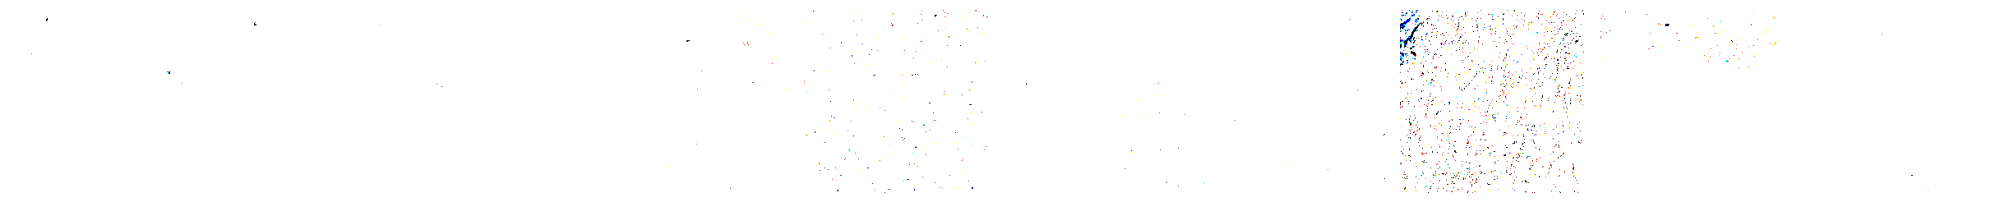

In [ ]:
plotImages(imgs)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title='Confusin Matrix', cmap = plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm = cm.astype('flot')/ cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  print(cm)
  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i,cm[i,j],
             horizontalalignment = "center",
             color="white" if cm[i,j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 2s 0us/step


In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

In [ ]:
for layer in model.layers[:-3]:
  layer.trainable = False

for layer in model.layers[:-7]:
  layer.trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
# Add a dropout layer with a dropout rate of 0.5
model.add(Dropout(0.5))
model.add(Dense(units=256, activation = 'relu'))

model.add(Dense(units=2, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy', AUC()])

In [ ]:
batch_data = train_batches[0][0]  # Access the first batch of data
batch_shape = batch_data.shape
print("Batch data shape:", batch_shape)

Batch data shape: (32, 224, 224, 3)


In [ ]:
train_batches.class_indices

{'Neg': 0, 'Pos': 1}

In [ ]:
history = model.fit(x= train_batches, validation_data = valid_batches, epochs = 25)

Epoch 1/25
46/46 [==============================] - 613s 13s/step - loss: 0.3438 - accuracy: 0.8873 - auc: 0.9516 - val_loss: 0.3462 - val_accuracy: 0.8938 - val_auc: 0.9659
Epoch 2/25
46/46 [==============================] - 17s 368ms/step - loss: 0.0632 - accuracy: 0.9744 - auc: 0.9978 - val_loss: 0.2402 - val_accuracy: 0.9375 - val_auc: 0.9783
Epoch 3/25
46/46 [==============================] - 18s 380ms/step - loss: 0.0100 - accuracy: 0.9959 - auc: 0.9999 - val_loss: 0.2733 - val_accuracy: 0.9250 - val_auc: 0.9775
Epoch 4/25
46/46 [==============================] - 17s 360ms/step - loss: 0.0052 - accuracy: 0.9979 - auc: 1.0000 - val_loss: 0.3172 - val_accuracy: 0.9500 - val_auc: 0.9594
Epoch 5/25
46/46 [==============================] - 18s 389ms/step - loss: 4.3621e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3573 - val_accuracy: 0.9438 - val_auc: 0.9649
Epoch 6/25
46/46 [==============================] - 18s 399ms/step - loss: 7.7891e-05 - accuracy: 1.0000 - auc: 1.0000 - v

In [ ]:
model.save(base+"FT_HER2Sample_VGG16")

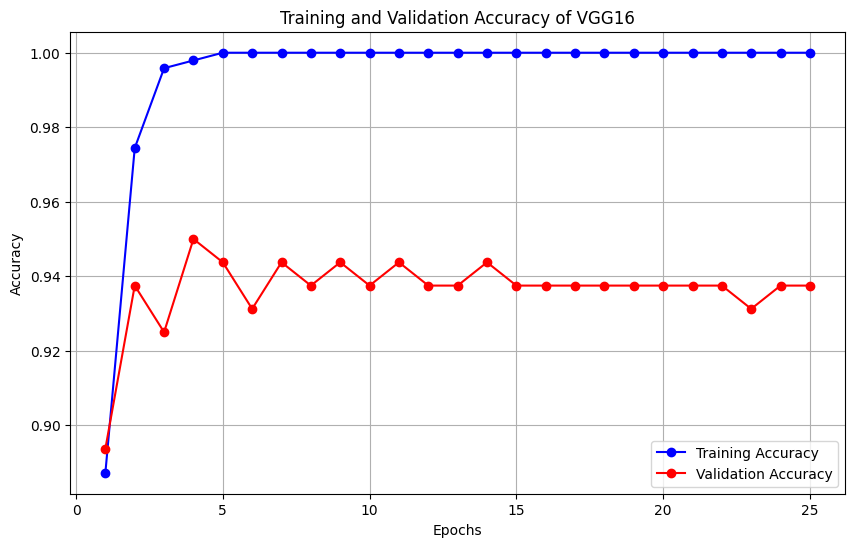

In [ ]:

# Extract training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, 26)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

test_loss, test_accuracy, AUC = model.evaluate(test_batches)
print("Testing Loss:", test_loss)
print("AUC", AUC)
print("Testing Accuracy:", test_accuracy)

15/15 [==============================] - 46s 3s/step - loss: 0.3109 - accuracy: 0.9708 - auc: 0.9821
Testing Loss: 0.3108750879764557
AUC 0.9821353554725647
Testing Accuracy: 0.9708333611488342


15/15 - 2s - 2s/epoch - 166ms/step
Confusion matrix, without normalization
[[145   0]
 [  7  88]]


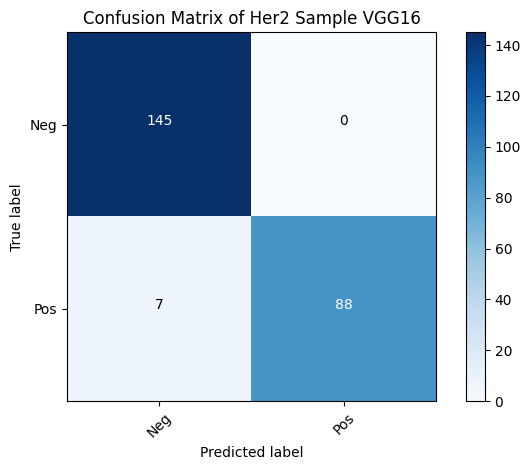

In [ ]:

predictions =model.predict(x= test_batches, verbose=2)
cm = confusion_matrix(y_true= test_batches.classes, y_pred = np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=classes, title = 'Confusion Matrix of Her2 Sample VGG16')

Load the model and Transfer Learning on BreakHiss 400X

In [ ]:
loaded_model = tf.keras.models.load_model(base+"FT_HER2Sample_VGG16")

In [ ]:
base = "/content/drive/MyDrive/Colab Notebooks/BCI_dataset/HE"

In [ ]:
train_path = os.path.join(base, 'train')
test_path =  os.path.join(base, 'test')
print((os.listdir(train_path)))

['03104_train_1+.png', '03105_train_2+.png', '03106_train_2+.png', '03107_train_2+.png', '03108_train_1+.png', '03109_train_2+.png', '03110_train_1+.png', '03111_train_2+.png', '03112_train_2+.png', '03113_train_2+.png', '03114_train_2+.png', '03115_train_2+.png', '03116_train_3+.png', '03117_train_3+.png', '03118_train_3+.png', '03119_train_2+.png', '03120_train_1+.png', '03121_train_3+.png', '03122_train_2+.png', '03123_train_2+.png', '03124_train_1+.png', '03125_train_2+.png', '03126_train_2+.png', '03127_train_2+.png', '03128_train_2+.png', '03129_train_3+.png', '03130_train_3+.png', '03131_train_1+.png', '03132_train_2+.png', '03133_train_1+.png', '03134_train_2+.png', '03135_train_0.png', '03136_train_3+.png', '03137_train_1+.png', '03138_train_1+.png', '03139_train_2+.png', '03140_train_2+.png', '03141_train_3+.png', '03142_train_2+.png', '03143_train_2+.png', '03144_train_2+.png', '03145_train_1+.png', '03146_train_0.png', '03162_train_3+.png', '03163_train_2+.png', '03164_trai

In [ ]:
# import os
# import numpy as np
# from PIL import Image

# # Create an empty list to collect all image file paths
# all_image_paths = []

# # Traverse through train, test, and valid directories to collect image file paths
# for subdir in ['train/benign', 'test/benign', 'train/malignant', 'test/malignant']:
#     subdir_path = os.path.join(base, subdir)
#     image_files = [os.path.join(subdir_path, filename) for filename in os.listdir(subdir_path)]
#     all_image_paths.extend(image_files)

# # Initialize lists to store pixel values for mean and std calculation
# red_channel_values = []
# green_channel_values = []
# blue_channel_values = []

# # Loop through all image file paths to collect pixel values for each channel
# for image_path in all_image_paths:
#     image = PIL.Image.open(image_path)
#     image = image.resize((224, 224))
#     img_array = np.array(image)

#     # Separate pixel values by color channel
#     red_channel_values.append(img_array[:, :, 0])
#     green_channel_values.append(img_array[:, :, 1])
#     blue_channel_values.append(img_array[:, :, 2])

# # Convert the lists of pixel values to NumPy arrays for each channel
# red_channel_values = np.array(red_channel_values)
# green_channel_values = np.array(green_channel_values)
# blue_channel_values = np.array(blue_channel_values)

# # Calculate mean and std for each color channel
# red_mean = np.mean(red_channel_values)
# green_mean = np.mean(green_channel_values)
# blue_mean = np.mean(blue_channel_values)

# red_std = np.std(red_channel_values)
# green_std = np.std(green_channel_values)
# blue_std = np.std(blue_channel_values)

# print("Red Channel - Mean:", red_mean, "Std:", red_std)
# print("Green Channel - Mean:", green_mean, "Std:", green_std)
# print("Blue Channel - Mean:", blue_mean, "Std:", blue_std)


In [ ]:
def custom_preprocess_input(image, red_mean, green_mean, blue_mean, red_std, green_std, blue_std):
    # Resize the image to 224x224 pixels
    # image = image.resize((224, 224))

    # Convert the image to a NumPy array
    img_array = np.array(image)

    # Normalize pixel values for each channel to the range [0, 1]
    img_array[:, :, 0] = (img_array[:, :, 0] - red_mean) / red_std
    img_array[:, :, 1] = (img_array[:, :, 1] - green_mean) / green_std
    img_array[:, :, 2] = (img_array[:, :, 2] - blue_mean) / blue_std

    # Clip values to ensure they are within [0, 1]
    # img_array = np.clip(img_array, 0, 1)

    # Rescale to [0, 224]
    img_array = img_array *224

    return img_array

In [ ]:
classes = os.listdir(train_path)
dataGenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, validation_split=0.5)

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), classes=classes, batch_size=32,class_mode='categorical',subset='training')
valid_batches = dataGenerator.flow_from_directory(directory= train_path, target_size = (224,224),classes = classes, batch_size = 16,class_mode='categorical',subset='validation')
test_batches =  dataGenerator.flow_from_directory(directory = test_path, target_size=(224,224),classes =classes, batch_size = 16, shuffle = False,class_mode='categorical',subset='training')

Found 0 images belonging to 3896 classes.
Found 0 images belonging to 3896 classes.
Found 0 images belonging to 3896 classes.


In [ ]:
image_path = base+'/train/benign'
image_files = os.listdir(image_path)
fig, axes = plt.subplots(2, 8, figsize=(15, 8))

for i in range(8):
    # Select a random image file
    random_image_file = random.choice(image_files)

    # Open and display the original image using Pillow
    image = os.path.join(image_path, random_image_file)
    img = PIL.Image.open(image)

    # Preprocess the image for VGG16
    img_preprocessed = img.resize((224, 224))  # Resize to 224x224 pixels
    img_preprocessed = custom_preprocess_input(img_preprocessed, 0.485*224, 0.456*224, 0.406*224, 0.229*224, 0.224*224, 0.225*224)  # Preprocess pixel values

    # Display the original image
    axes[0, i].imshow(img)
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')  # Turn off axis labels

    # Display the preprocessed image
    axes[1, i].imshow(img_preprocessed)
    axes[1, i].set_title("Preprocessed")
    axes[1, i].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

FileNotFoundError: ignored

In [ ]:
from tensorflow.keras.metrics import AUC

model = Sequential()

model = Sequential()
for layer in loaded_model.layers[:-3]:
  model.add(layer)


for layer in model.layers:
  layer.trainable = False


model.add(Dense(units=256, activation = 'relu'))
model.add(Dense(units=2, activation = 'softmax'))
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy', AUC()])

In [ ]:
history = model.fit(x= train_batches, validation_data = valid_batches, epochs = 25, verbose= 2)

In [ ]:
# Extract training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, 26)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Extract training and validation accuracy
training_accuracy = history.history['loss']
validation_accuracy = history.history['val_loss']

# Create a range of epochs
epochs = range(1, 26)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training loss')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation loss')
plt.title('Training and Validation loss of VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()